# Fisher Information

Autodiff doesn't just make it faster to solve optimization and inference problems - it also allows you to use powerful ideas in statistics that require second derivatives that are intractable analytically or with finite differences.

The Fisher Information Matrix, or the inverse of the Hessian of the likelihood, can be used for
- the [Laplace approximation](https://www.sciencedirect.com/topics/mathematics/laplace-approximation) to a posterior for variational inference, giving you the Gaussian covariance of the posterior near the maximum likelihood point;
- Fisher forecasting, where you calculate this for an instrument or experiment at expected parameters, to predict how well it will constrain them; and
- optimal design, as the [Cramér-Rao lower bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound) on the precision of an experiment is the inverse of the Fisher information matrix - so you want to make this as tight as possible!

Because `jax` lets us compute the Hessian of our loss function, we can use the Fisher matrix for variational inference without MCMC, and also more powerfully _as an objective function_ to optimize a telescope design: why bother engineering a PSF for a particular goal, when you could model the system _end to end_ and optimize the precision of the Fisher forecast of the parameter of interest?

This notebook follows on from [Phase Mask Design](designing_a_mask.ipynb) and will reuse some of the same code without repeating explanations.

Right, let's import some things.

In [22]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as np

import numpy as onp
import matplotlib.pyplot as plt

import functools as ft
import pickle as p
from tqdm import tqdm

import optax
import equinox as eqx

import dLux as dl
from dLux.helpers import *
from dLux.bayes import *
from dLux.zernike import zernike_basis
from dLux.utils.models import toliman_layers # pre-built Toliman pupils
from dLux.plotting import plot_batch

from chainconsumer import ChainConsumer

%matplotlib inline

In [2]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.facecolor'] = 'w'
# plt.rcParams.keys()

<Figure size 432x288 with 0 Axes>

In [3]:
r = arcsec2rad(10)
positions = np.array([[r/2, 0], [-r/2, 0]])
fluxes = np.array([1e6, 1e6])
wavels = 1e-9 * np.linspace(545, 645, 9)

In [5]:
# # Base layers
lays = toliman_layers()
aperture = lays[2].array
wf_npix = aperture.shape[0]

# # Zernike Basis
zern_basis = zernike_basis(10, wf_npix, outside=0.)[3:]
zcoeffs = np.zeros(len(zern_basis))

# Detector Layers
jitter = 1.
saturation = 1e6
det_layers = [dl.ApplyJitter(jitter), dl.ApplySaturation(saturation)]
det_layers = []

Load the saved basis vectors from the tutorial on [designing a mask](../designing_a_mask.ipynb).

In [6]:
basis = np.load("files/basis.npy")
wavels = 1e-9 * np.linspace(595, 695, 6)

Define the coordinate grid of the basis vectors:

In [7]:
ppf = get_ppf(wavels)
min_fringe = 1
max_fringe = 10

rmin = min_fringe/ppf
rmax = max_fringe/ppf
print(rmin, rmax)

5.239384615384616 52.39384615384616


Generate a random pupil using CLIMB and random basis coefficients:

In [11]:
onp.random.seed(i)
coeffs = norm_rand(0, 100, [len(basis)])

latent_layers = toliman_layers([
                        dl.ApplyBasisCLIMB(basis, coeffs, np.mean(wavels)),
                        dl.ApplyBasisOPD(zern_basis, zcoeffs)],
                        det_npix=200)
osys = dl.OpticalSystem(latent_layers, 
                            wavels=wavels, 
                            positions=positions, 
                            fluxes=fluxes,
                            detector_layers=det_layers)

Visualize the PSF:

Text(0.5, 1.0, 'Input PSF')

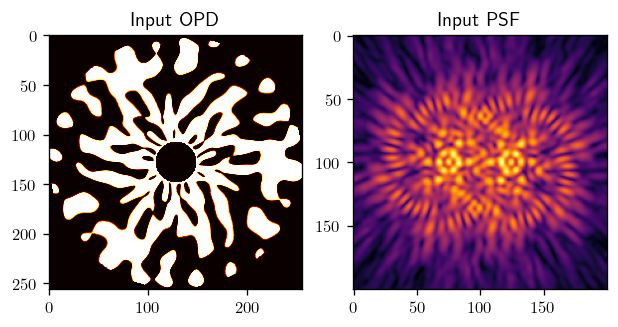

In [12]:
psf = osys()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6.0,3.3))
ax1.imshow(osys.layers[2].array*osys.layers[4].get_binary_phase(),cmap='hot')
ax1.set_title('Input OPD')

psf_in = osys()
ax2.imshow(psf_in**0.25)
ax2.set_title('Input PSF')

Now we are going to define a bunch of functions to help us specify binary parameters. This interface is under development; we are testing a new Layer, `Source`, which will allow you to manipulate multiple resolved and unresolved sources and place them appropriately. For the purposes of this tutorial, we will just define some essentials here.

In [13]:
from jax.scipy.stats import norm

def perturb_r_phi(positions, r_shift, phi_shift):
    """
    Perturbs binary by separation and angle
    """
    p0, p1 = positions
    dp = p1 - p0
    r, phi = cart2polar(dp[0], dp[1])
    
    r += r_shift
    phi += phi_shift
    shift = polar2cart(r, phi)
    
    positions = np.array([p1 - shift, p0 + shift])
    return positions

def perturb_flux(fluxes, cont_shift):
    """
    Perturbs binary by contrast
    """
    f0, f1 = fluxes
    cont = fluxes[0]/fluxes[1]
    cont += cont_shift
    fluxes = np.array([cont*f1, f0/cont])
    return fluxes

def binary_param(X, model, get_params=False, prior=False):
    
    if get_params:
        X = np.zeros(100)
    indx = 0
    params = []
    
    # Positions
    r_shift = arcsec2rad(X[indx])
    r_shift *= 1 if prior else 1
    phi_shift = arcsec2rad(X[indx+1])
    phi_shift *= 1 if prior else 1
    positions = perturb_r_phi(model.positions, r_shift, phi_shift)
    model = eqx.tree_at(lambda model: model.positions, model, positions)
    params+= ["r (arcsec)", "$\phi (arcsec)$"]
    indx += 2
    
    # Fluxes
    cont_shift = X[indx]
    cont_shift *= 1 if prior else 1
    fluxes = perturb_flux(model.fluxes, cont_shift)
    model = eqx.tree_at(lambda model: model.fluxes, model, fluxes)
    params.append('$f_A/f_B$')
    indx += 1
    
    # Wavel
    wavel_shift = X[indx]
    wavel_shift *= norm.pdf(X[indx],  scale=1) if prior else 1
    wavels = model.wavels + (wavel_shift * 1e-9)
    model = eqx.tree_at(lambda model: model.wavels, model, wavels)
    params.append("$\lambda (nm)$")
    indx += 1
    
    # Plate scale
    pscale = X[indx]
    pscale *= norm.pdf(X[indx]) if prior else 1
    pscale = model.layers[-1].pixel_scale_out + (pscale)
    model = eqx.tree_at(lambda model: model.layers[-1].pixel_scale_out, model, pscale)
    params.append("Pscale (m)")
    indx += 1
    
    
    ###################################
    # Coeffs
    coeffs = model.layers[-2].coeffs
    
    # Evens
    coeff_shift = X[indx:indx+3]
    coeffs = coeffs.at[:3].add((coeff_shift * 1e-9))
    params += ["Defoc", "AstigX", "AstigY"]
    indx += 3
    
    # Odds
    coeff_shift = X[indx:indx+4]
    coeffs = coeffs.at[3:].add((coeff_shift * 1e-9))
    params += ["ComaX", "ComaY", "TfoilX", "TfoilY"]
    indx += 4
    
    # Update Coeffs
    model = eqx.tree_at(lambda model: model.layers[-2].coeffs, model, coeffs)
    ##################################
    
    if get_params:
        return np.zeros(indx), params
    return model

def apply_binary_params(X, model, prior=False):
    return binary_param(X, model, prior=prior)

Define a loss function and specify that we are only optimizing over the CLIMB basis coefficients:

In [18]:
# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, osyses)

# Set filtering Tree
filter_spec = eqx.tree_at(lambda osys: osys.layers[4].coeffs, filter_spec[i], replace=True)
    
@eqx.filter_jit
@ft.partial(eqx.filter_value_and_grad, arg=filter_spec)
def fim_loss_func(model, X, logpri_fn, update_fn):
    psf = model()
    loss = calc_ent(logpri_fn, X, psf, model, update_fn)
    return loss

Call the loss function once to compile:

In [20]:
%%time
X, params = binary_param(None, osys, get_params=True)
loss, grads = fim_loss_func(osys, X, poiss_logpri, binary_param)
print("Initial Loss: {}".format(loss))

Initial Loss: -49.55926518914166
CPU times: user 48.9 s, sys: 2.05 s, total: 50.9 s
Wall time: 11.8 s


Now run gradient descent!

In [24]:
optim = optax.adam(1e1)

model = osys
opt_state = optim.init(model)

errors, grads_out, models_out = [], [], []
with tqdm(range(50),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = fim_loss_func(model, X, poiss_logpri, binary_param)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        models_out.append(model)
        errors.append(loss)
        grads_out.append(grads)
    
        t.set_description("Loss: {:.3f}".format(loss)) # update the progress bar

Loss: -53.210: 100%|████████████████████████████| 50/50 [09:35<00:00, 11.51s/it]


Text(0.5, 1.0, 'Final PSF')

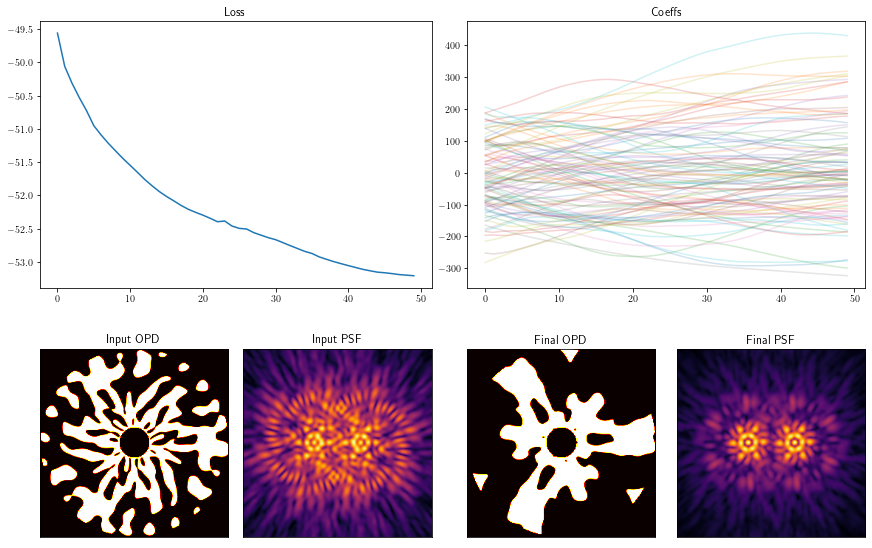

In [25]:
coeffs_out = np.array([model.layers[4].coeffs for model in models_out])

mosaic = """
    AABB
    CDEF
    """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['C','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])


axes['A'].plot(np.array(errors))
axes['A'].set_title("Loss")

axes['B'].set_title("Coeffs")
axes['B'].plot(coeffs_out[:], alpha=0.2)

model_in = osys
axes['C'].imshow(model_in.layers[2].array*model_in.layers[4].get_binary_phase(),cmap='hot')
axes['C'].set_title('Input OPD')

psf_in = model_in()
axes['D'].imshow(psf_in**0.25)
axes['D'].set_title('Input PSF')

final = models_out[-1]
axes['E'].imshow(final.layers[2].array*final.layers[4].get_binary_phase(),cmap='hot')
axes['E'].set_title('Final OPD')

psf_out = final()
axes['F'].imshow(psf_out**0.25)
axes['F'].set_title('Final PSF')

Let's calculate the covariance matrix elements:

In [28]:
%%time
covs = calc_cov(poiss_logpri, X, final(), final, binary_param)

CPU times: user 27.9 s, sys: 3.16 s, total: 31.1 s
Wall time: 13.2 s


And using [ChainConsumer](https://samreay.github.io/ChainConsumer/) we can easily visualize this covariance:

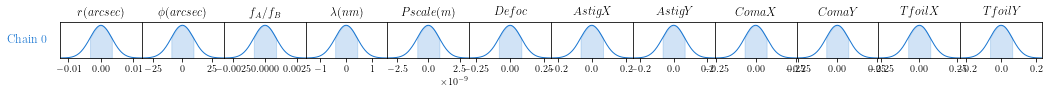

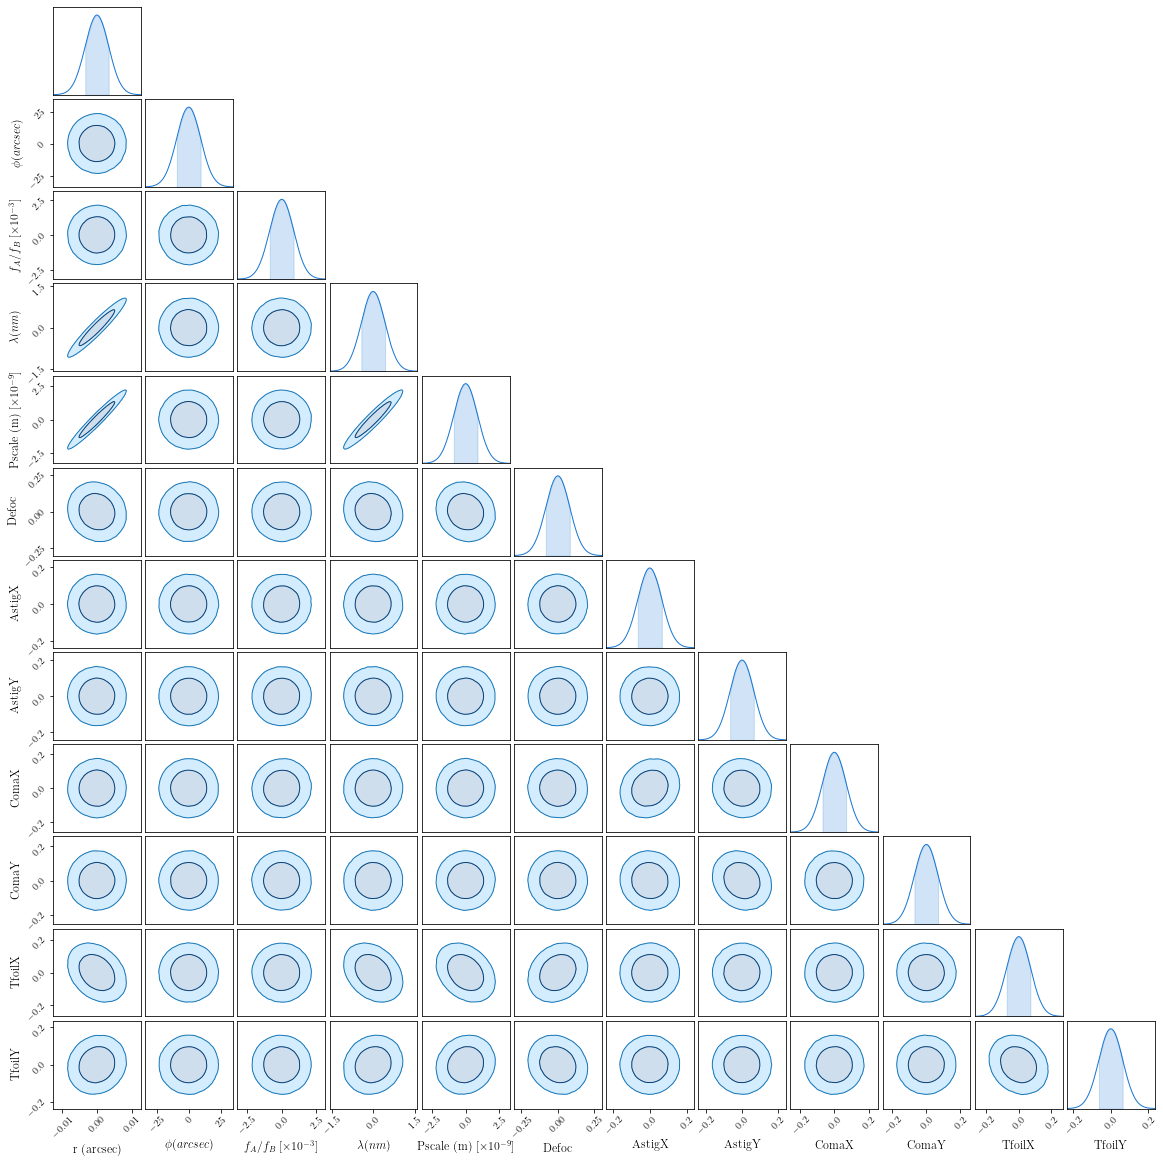

In [29]:
c = ChainConsumer()
c.add_covariance(X, covs, parameters=params)
    
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = c.plotter.plot_summary()
fig = c.plotter.plot()

We see that in this narrowband simulation, most parameters aren't tightly correlated, but separation, plate scale and wavelength are almost indistinguishable - this makes sense, as they affect the PSF in the same way! Only independent constraints on λ can save us here. If you want to do precise astrometry, you have to nail down your plate scale and your spectrum.

This is why in the Toliman telescope design we superimpose a grating over our pupil \([design paper, Fig 6](https://authors.library.caltech.edu/92050/1/107011J.pdf)\) - so we can measure a stellar spectrum and separate this from the astrometry.